In [1]:
import os

import sys
sys.path.append("C:\\Users\\User\\PycharmProjects\\GIEBN\\src")
sys.path.append("C:\\Users\\User\\PycharmProjects\\GIEBN")
sys.path.append("C:\\Users\\User\\PycharmProjects\\GIEBN\\venv")

path = os.getcwd()

curr_path = path.replace('\\', '/')
head_place = curr_path.find('GIEBN')
main_path = curr_path[:head_place]+'GIEBN'
main_path

'c:/Users/User/PycharmProjects/GIEBN'

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline, make_union
from sklearn.datasets import make_regression

from sklearn.model_selection import train_test_split

from auxiliary.auxiliary import construct_by_kmeans

from pgmpy.factors.discrete.CPD import TabularCPD
from pgmpy.models import BayesianNetwork
import yodo.yodo
import matplotlib.pyplot as plt
from pgmpy.estimators import PC, BicScore, K2Score
from pgmpy.inference import VariableElimination
from bamt.networks.discrete_bn import DiscreteBN
from bamt_inherited.networks.discrete import DiscreteBNGI
import shap

from tqdm import tqdm

imagespath = 'C://Users/User/PycharmProjects/GIEBN/experiments/shaplime/images'

In [1]:
%run ../common_code.ipynb

In [4]:
data = pd.read_csv("../../datasets/credit.csv")
print(data.columns)
#data = data.reset_index().drop(columns=["index"])
n_features = data.shape[1]-1
n = data.shape[0]
data["default"] = (data["NumberOfTimes90DaysLate"] > 0).astype(int)
data.drop(columns=["NumberOfTimes90DaysLate", 'NumberOfTime60-89DaysPastDueNotWorse', 'SeriousDlqin2yrs',
                   'NumberOfTime30-59DaysPastDueNotWorse'], inplace=True)
n_features = data.shape[1]-1
n = data.shape[0]
data.rename(columns={feat: "".join(feat.split("-")) for feat in data.columns}, inplace=True)
target = "default"
features = data.columns.difference([target]).tolist()

data.head(10)

Index(['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'SeriousDlqin2yrs'],
      dtype='object')


,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfDependents,default
0,0.006999,38,0.302150,5440.0,4,1,3,0
1,0.704592,63,0.471441,8000.0,9,1,0,0
2,0.063113,57,0.068586,5000.0,17,0,0,0
3,0.368397,68,0.296273,6250.0,16,2,0,0
4,1.000000,34,0.000000,3500.0,0,0,1,0
5,0.051799,63,0.770687,4700.0,16,1,1,0
6,0.648733,40,0.402060,6600.0,10,2,3,0
7,0.767270,33,0.338390,5800.0,10,0,3,0
8,0.190111,27,0.164605,3960.0,6,0,1,0
9,0.139989,65,0.258397,6400.0,6,1,0,0


In [5]:
data_tv, data_test = train_test_split(data, test_size=0.15, random_state=42,
                                      stratify=data[target])

data_train, data_val = train_test_split(data_tv, test_size=0.15, random_state=42,
                                      stratify=data_tv[target])

data_train[target].mean(), data_val[target].mean() , data_test[target].mean()

(0.18476190476190477, 0.18488972313467855, 0.18460925039872408)

In [6]:
data_val.shape

(2131, 8)

In [7]:
model = GradientBoostingClassifier(n_estimators=30)
#model = LogisticRegression()
model.fit(data_train[features], data_train[target])

GradientBoostingClassifier(n_estimators=30)

In [8]:
data_errors = data_val.copy(deep=True)
probs = model.predict_proba(data_val[features])[:, 1]
data_errors["inconf_error"] = (1-probs)*data_val[target]+(probs)*(1-data_val[target]) #inconfidence measure: the larger the worser inconfidence

data_errors.drop(columns=[target], inplace=True)
data_errors.head()

,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfDependents,inconf_error
700,1.000000,54,0.178841,3175.0,1,0,1,0.485031
15405,1.000000,35,0.000000,1800.0,0,0,0,0.573427
16522,0.197965,49,0.120713,9708.0,7,2,2,0.061616
3834,0.107234,80,0.271530,2960.0,8,1,0,0.054690
10225,0.594406,39,0.537291,4665.0,6,1,4,0.177077


In [9]:
disc_data, pipeline_data = discretize(data_errors, features+["inconf_error"], icat=None, icont=list(range(n_features+1)))
disc_data

,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfDependents,inconf_error
0,2,1,0,0,0,1,2,2
1,2,0,0,0,0,1,1,2
2,1,1,0,2,0,2,2,0
3,0,2,1,0,0,2,1,0
4,1,0,2,1,0,2,2,1
...,...,...,...,...,...,...,...,...
2126,2,0,0,0,0,1,2,2
2127,2,0,0,1,0,1,1,2
2128,1,1,0,2,1,2,2,1
2129,2,0,0,1,0,1,2,2


In [10]:
from itertools import product

In [11]:
def extract_categories(data):
    return [f"{feat}_{int(k)}" for feat in data.columns for k in
            sorted(data[feat].unique())]
categories = extract_categories(disc_data)
encoder = OneHotEncoder(sparse=False)
disc_data_encoded = pd.DataFrame(encoder.fit_transform(X=disc_data), columns=categories, dtype='uint8')
disc_data_encoded

,RevolvingUtilizationOfUnsecuredLines_0,RevolvingUtilizationOfUnsecuredLines_1,RevolvingUtilizationOfUnsecuredLines_2,age_0,age_1,age_2,DebtRatio_0,DebtRatio_1,DebtRatio_2,MonthlyIncome_0,...,NumberOfOpenCreditLinesAndLoans_0,NumberOfOpenCreditLinesAndLoans_1,NumberOfOpenCreditLinesAndLoans_2,NumberRealEstateLoansOrLines_1,NumberRealEstateLoansOrLines_2,NumberOfDependents_1,NumberOfDependents_2,inconf_error_0,inconf_error_1,inconf_error_2
0,0,0,1,0,1,0,1,0,0,1,...,1,0,0,1,0,0,1,0,0,1
1,0,0,1,1,0,0,1,0,0,1,...,1,0,0,1,0,1,0,0,0,1
2,0,1,0,0,1,0,1,0,0,0,...,1,0,0,0,1,0,1,1,0,0
3,1,0,0,0,0,1,0,1,0,1,...,1,0,0,0,1,1,0,1,0,0
4,0,1,0,1,0,0,0,0,1,0,...,1,0,0,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2126,0,0,1,1,0,0,1,0,0,1,...,1,0,0,1,0,0,1,0,0,1
2127,0,0,1,1,0,0,1,0,0,0,...,1,0,0,1,0,1,0,0,0,1
2128,0,1,0,0,1,0,1,0,0,0,...,0,1,0,0,1,0,1,0,1,0
2129,0,0,1,1,0,0,1,0,0,0,...,1,0,0,1,0,0,1,0,0,1


In [12]:
def gbn_training_pipeline(gbn, disc_data_encoded, error_name, categories):
    gbn.add_nodes({"types": {feat: "disc" for feat in disc_data_encoded.columns}})
    features_cats = [x for x in disc_data_encoded.columns if error_name not in x]
    error_cats = [x for x in disc_data_encoded.columns if error_name in x]

    blacklist = [(x, y) for x, y in product(error_cats, features_cats)] \
            + [(x, y) for x, y in product(categories, categories) if x.split("_")[:-1]==y.split("_")[:-1]]

    gbn.add_edges(disc_data_encoded, scoring_function=("K2", BicScore), params={"bl_add": blacklist})
    gbn.fit_parameters(data=disc_data_encoded, n_jobs=1)
    

In [13]:
gbn = DiscreteBNGI(imagespath)

gbn_training_pipeline(gbn, disc_data_encoded, 'inconf_error', categories)


2025-04-15 10:32:56,047 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-04-15 10:32:56,048 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-04-15 10:32:56,049 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-04-15 10:32:56,050 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-04-15 10:32:56,052 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-04-15 10:32:56,053 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-04-15 10:32:56,053 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-04-15 10:32:56,054 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-04-15 10:32:56,055 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-04-15 10:32:56,056 | ERROR    | GraphUtil

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [46]:
import random
def get_all_predecessors(gbn, nodes):
    res = []
    iter_list=nodes
    while len(iter_list)>0:
        node = iter_list[0]
        iter_list=iter_list[1:]
        if gbn[node] is not None:
            pred = gbn[node].disc_parents
            if pred is not None:
                for p in pred:
                    if p not in res and p not in nodes:
                        res.append(p)
                        iter_list.append(p)
    return res


def get_prob(gbn, node, nodes_values):
    if len(gbn[node].disc_parents)==0:
        return gbn.get_dist(node)['cprob'][int(nodes_values[node])]
    else:
        return gbn.get_dist(node, nodes_values)[int(nodes_values[node])]


def calculate_cond_prob_support(gbn, e_grad, x_grad):
    pgmpy_gbn = gbn.to_pgmpy()
    if x_grad in gbn.isolated_nodes:
        return 0
    inference = VariableElimination(pgmpy_gbn)
    res_infer = inference.query([e_grad, x_grad])
    dict_to_get_value = {e_grad:1, x_grad:1}
    
    return res_infer.get_value(**dict_to_get_value)


def calculate_mutual_information(gbn, feat1, feat2, grad_map):


    joint_values = {(x, y): calculate_cond_prob_support(gbn, x, y)
                    for x, y in product(grad_map[feat1], grad_map[feat2])}
    
    all_sum = sum([x for x in joint_values.values()])

    if all_sum == 0: # all gradations of feats are independent
        return 0

    joint_values = {k: v/all_sum for k, v in joint_values.items()}
    marg_probs = {}
    for grad in grad_map[feat1]:
        s=sum([v for k, v in joint_values.items() if k[0]==grad])
        marg_probs[grad]=s

    for grad in grad_map[feat2]:
        s=sum([v for k, v in joint_values.items() if k[1]==grad])
        marg_probs[grad]=s

    mutual_info = sum([joint_values[(x, y)]*np.log(joint_values[(x, y)]/(marg_probs[x]*marg_probs[y]) if marg_probs[x]*marg_probs[y]*joint_values[(x, y)] > 0 else 0
                                                   ) for x, y in product(grad_map[feat1], grad_map[feat2])])

    return mutual_info



In [15]:
pgmpy_gbn = gbn.to_pgmpy()

In [16]:
feat_to_grad = {}
for feat in features+['inconf_error']:
    feat_to_grad[feat]=[grad for grad in disc_data_encoded.columns if feat in grad]
feat_to_grad

{'DebtRatio': ['DebtRatio_0', 'DebtRatio_1', 'DebtRatio_2'],
 'MonthlyIncome': ['MonthlyIncome_0', 'MonthlyIncome_1', 'MonthlyIncome_2'],
 'NumberOfDependents': ['NumberOfDependents_1', 'NumberOfDependents_2'],
 'NumberOfOpenCreditLinesAndLoans': ['NumberOfOpenCreditLinesAndLoans_0',
  'NumberOfOpenCreditLinesAndLoans_1',
  'NumberOfOpenCreditLinesAndLoans_2'],
 'NumberRealEstateLoansOrLines': ['NumberRealEstateLoansOrLines_1',
  'NumberRealEstateLoansOrLines_2'],
 'RevolvingUtilizationOfUnsecuredLines': ['RevolvingUtilizationOfUnsecuredLines_0',
  'RevolvingUtilizationOfUnsecuredLines_1',
  'RevolvingUtilizationOfUnsecuredLines_2'],
 'age': ['age_0', 'age_1', 'age_2'],
 'inconf_error': ['inconf_error_0', 'inconf_error_1', 'inconf_error_2']}

In [17]:
calculate_mutual_information(gbn, 'inconf_error', 'RevolvingUtilizationOfUnsecuredLines', feat_to_grad)

0.03709942249817465

In [18]:
gbn.nodes[0].name

'DebtRatio_1'

In [19]:
feat_to_grad = {}
for feat in features+['inconf_error']:
    feat_to_grad[feat]=[grad for grad in disc_data_encoded.columns if feat in grad]
feat_to_grad

{'DebtRatio': ['DebtRatio_0', 'DebtRatio_1', 'DebtRatio_2'],
 'MonthlyIncome': ['MonthlyIncome_0', 'MonthlyIncome_1', 'MonthlyIncome_2'],
 'NumberOfDependents': ['NumberOfDependents_1', 'NumberOfDependents_2'],
 'NumberOfOpenCreditLinesAndLoans': ['NumberOfOpenCreditLinesAndLoans_0',
  'NumberOfOpenCreditLinesAndLoans_1',
  'NumberOfOpenCreditLinesAndLoans_2'],
 'NumberRealEstateLoansOrLines': ['NumberRealEstateLoansOrLines_1',
  'NumberRealEstateLoansOrLines_2'],
 'RevolvingUtilizationOfUnsecuredLines': ['RevolvingUtilizationOfUnsecuredLines_0',
  'RevolvingUtilizationOfUnsecuredLines_1',
  'RevolvingUtilizationOfUnsecuredLines_2'],
 'age': ['age_0', 'age_1', 'age_2'],
 'inconf_error': ['inconf_error_0', 'inconf_error_1', 'inconf_error_2']}

In [20]:
#gbn.plot("credit_classif_other.html")

In [21]:
def error_based_importance(data, error_col, feature, feat_to_grad):
    error_probs = {grad: data[grad].mean() for grad in disc_data_encoded.columns if error_col in grad}
    s=0
    for grad in feat_to_grad[feature]:
        sub_sum = 0
        for e, p in error_probs.items():
            cprob = data[(data[e]==1)&(data[grad]==1)].shape[0]/data.shape[0]/data[grad].mean()
            sub_sum+=cprob*np.log(cprob/p) if cprob>0 else 0
        s+=data[grad].mean()*sub_sum
    return s

def mutual_information(data, error_col, feature, feat_to_grad):
    s=0
    for e_grad, f_grad in product([grad for grad in disc_data_encoded.columns if error_col in grad], 
                                  feat_to_grad[feature]):
        joint_prob = data[(data[e_grad]==1)&(data[f_grad]==1)].shape[0]/data.shape[0]
        px, py = data[e_grad].mean(), data[f_grad].mean()

        s+=joint_prob*np.log(joint_prob/px/py) if joint_prob>0 else 0

    return s

def error_based_importance_features(data, error_col, features, feat_to_grad):
    df = pd.DataFrame(columns=['Feature', 'Metric value'])
    for i, feature in enumerate(features):
        val = error_based_importance(data, error_col, feature, feat_to_grad)
        df.loc[i, :] = [feature, val]
    return df

def error_based_importance_features_bn(gbn, error_col, features, feat_to_grad):
    df = pd.DataFrame(columns=['Feature', 'Metric value'])
    for i, feature in tqdm(enumerate(features), total=len(features)):
        val = calculate_mutual_information(gbn, error_col, feature, feat_to_grad)
        df.loc[i, :] = [feature, val]
    return df

In [22]:
df_val_new=error_based_importance_features_bn(gbn, 'inconf_error', features, feat_to_grad)
df_val_new

100%|██████████| 7/7 [00:00<00:00, 17.26it/s]


,Feature,Metric value
0,DebtRatio,0.004447
1,MonthlyIncome,0.000707
2,NumberOfDependents,0.001157
3,NumberOfOpenCreditLinesAndLoans,0.00031
4,NumberRealEstateLoansOrLines,0.001545
5,RevolvingUtilizationOfUnsecuredLines,0.037099
6,age,0.013552


In [23]:
df_val=error_based_importance_features(disc_data_encoded, 'inconf_error', features, feat_to_grad)
df_val

,Feature,Metric value
0,DebtRatio,0.023985
1,MonthlyIncome,0.037991
2,NumberOfDependents,0.002945
3,NumberOfOpenCreditLinesAndLoans,0.064241
4,NumberRealEstateLoansOrLines,0.04255
5,RevolvingUtilizationOfUnsecuredLines,0.338584
6,age,0.04856


In [24]:
df2 = df_val[['Feature']]
df2['Metric value 1 rank'] = df_val['Metric value'].rank()
df2['Metric value 2 rank'] = df_val_new['Metric value'].rank()
df2

,Feature,Metric value 1 rank,Metric value 2 rank
0,DebtRatio,2.0,5.0
1,MonthlyIncome,3.0,2.0
2,NumberOfDependents,1.0,3.0
3,NumberOfOpenCreditLinesAndLoans,6.0,1.0
4,NumberRealEstateLoansOrLines,4.0,4.0
5,RevolvingUtilizationOfUnsecuredLines,7.0,7.0
6,age,5.0,6.0


In [25]:
def plot_bar_chart(df_values, fontsize=14):
    df_values.plot.barh(figsize=(10, 6))
    ax=plt.gca()
    ax.barh(df_values['Feature'], df_values['Metric value'], height=0.75)
    _, xmax = plt.xlim()
    for i, row in df_values.iterrows():
        ax.text(row['Metric value'] if 2*row['Metric value'] < xmax else xmax-row['Metric value'], 
                i, row['Feature'], color='black', fontweight='bold', fontsize=fontsize, ha='left', va='center')

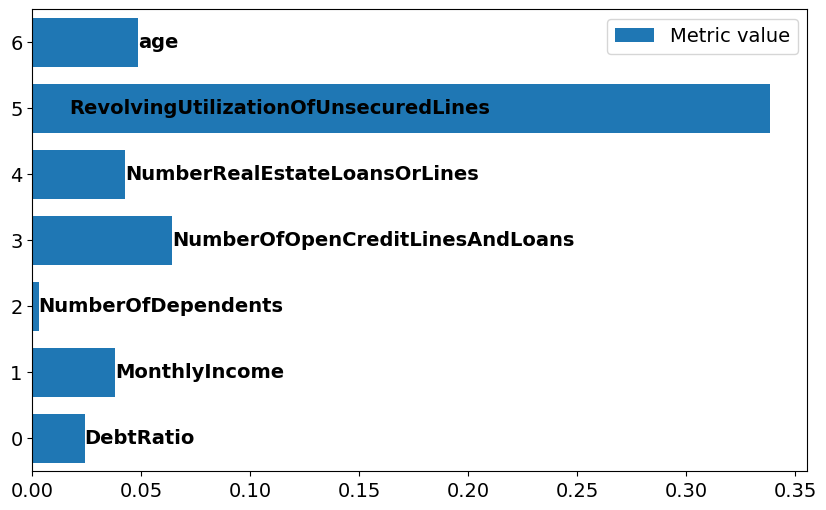

In [29]:
plot_bar_chart(df_val, fontsize=14)

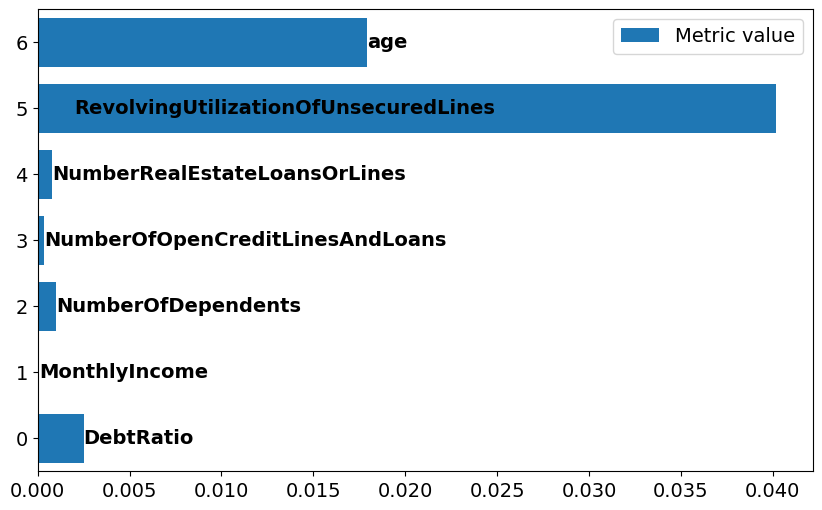

In [30]:
plot_bar_chart(df_val_new, fontsize=14)

In [26]:
from sklearn.metrics import roc_auc_score, log_loss
from copy import copy

In [27]:
def elimination_experiment(model, data_dict, metric_dict, importances, direction='asc'):
    ordered_features = importances.sort_values(by='Metric value', ascending=(direction=='asc'))
    ordered_features = ordered_features['Feature'].tolist()
    df_res = pd.DataFrame(columns=['n_features', 'last_excluded']+[m_name for m_name in metric_dict.keys()]\
                                                                +[m_name+'_change, %' for m_name in metric_dict.keys()])
    for i in range(len(ordered_features)):
        model_c = copy(model)
        features_chosen = ordered_features[i:]
        model_c.fit(data_dict['train'][features_chosen], data_dict['train'][target])

        y_pred_test = model_c.predict_proba(data_dict['test'][features_chosen])[:, 1]
        metrics_vals = []
        metrics_chng=[]
        for m_name, metric in metric_dict.items():
            val = metric(data_dict['test'][target], y_pred_test)
            metrics_vals.append(np.round(val, 3))
            if i == 0:
                metrics_chng.append(0)
            else:
                base = df_res.loc[0, m_name]
                metrics_chng.append(np.round((val-base)/base*100, 3))
        df_res.loc[i, :] = [len(features_chosen), ordered_features[i-1] if i > 0 else '-']+metrics_vals+metrics_chng
    return df_res



In [28]:
metric_dict = {
    'ROC AUC': lambda x, y: roc_auc_score(x,y)*100,
    'log_loss': lambda x, y: log_loss(x, y)
}

data_dict = {'train': data_train,
             'test': data_test,
             'val': data_val}

elimination_experiment(model, data_dict, metric_dict,
                       df_val, 'asc')

,n_features,last_excluded,ROC AUC,log_loss,"ROC AUC_change, %","log_loss_change, %"
0,7,-,80.189,0.391,0,0
1,6,NumberOfDependents,80.155,0.391,-0.042,0.071
2,5,DebtRatio,80.034,0.392,-0.193,0.258
3,4,MonthlyIncome,79.841,0.393,-0.435,0.438
4,3,NumberRealEstateLoansOrLines,79.53,0.394,-0.822,0.794
5,2,age,79.353,0.395,-1.042,1.071
6,1,NumberOfOpenCreditLinesAndLoans,78.293,0.4,-2.365,2.352


In [29]:
elimination_experiment(model, data_dict, metric_dict,
                       df_val, 'desc')

,n_features,last_excluded,ROC AUC,log_loss,"ROC AUC_change, %","log_loss_change, %"
0,7,-,80.189,0.391,0,0
1,6,RevolvingUtilizationOfUnsecuredLines,72.306,0.43,-9.83,9.871
2,5,NumberOfOpenCreditLinesAndLoans,68.598,0.446,-14.454,14.143
3,4,age,67.055,0.452,-16.379,15.57
4,3,NumberRealEstateLoansOrLines,65.675,0.456,-18.1,16.513
5,2,MonthlyIncome,56.868,0.471,-29.083,20.551
6,1,DebtRatio,55.076,0.476,-31.317,21.618


In [30]:
elimination_experiment(model, data_dict, metric_dict,
                       df_val_new, 'asc')

,n_features,last_excluded,ROC AUC,log_loss,"ROC AUC_change, %","log_loss_change, %"
0,7,-,80.189,0.391,0,0
1,6,NumberOfOpenCreditLinesAndLoans,79.727,0.395,-0.576,0.964
2,5,MonthlyIncome,79.387,0.397,-1.001,1.407
3,4,NumberOfDependents,79.339,0.397,-1.06,1.444
4,3,NumberRealEstateLoansOrLines,78.921,0.399,-1.581,1.957
5,2,DebtRatio,78.687,0.4,-1.873,2.276
6,1,age,78.293,0.4,-2.365,2.352


In [31]:
def add_extra_features(data, features_orig,extra_size=0.5, mode='random', random_seed=42):
    extra_cnt = round(len(features_orig)/(1-extra_size))-len(features_orig)
    data_c = data.copy(deep=True)
    np.random.seed(random_seed)
    if mode=='random':
        for i in range(extra_cnt):
            std = np.random.uniform(0.75, 1.25)
            data_c[f'extra_{i+1}'] = np.random.normal(scale=std, size=data_c.shape[0])
    elif mode=='noisy':
        for i in range(extra_cnt):
            feature_chosen = np.random.choice(features_orig, size=1)[0]
            std = data[feature_chosen].std()
            data_c[f'extra_{i+1}'] = 0.5*data[feature_chosen]+0.5*np.random.normal(scale=std, size=data_c.shape[0])
    elif mode=='prod':
        first_subset=np.random.choice(features_orig, size=extra_cnt)
        second_subset=np.random.choice(features_orig, size=extra_cnt)
        i=0
        for feat1, feat2 in zip(first_subset, second_subset):
            data_c[f'extra_{i+1}'] = data[feat1]*data[feat2]
            i+=1
    return data_c

In [32]:
from sklearn.feature_selection import SelectKBest

In [268]:
data_corr = add_extra_features(data, features, extra_size=0.75, mode='prod')

In [269]:
data_dict_corr = {}

data_tv, data_dict_corr['test'] = train_test_split(data_corr, test_size=0.15, random_state=42,
                                      stratify=data_corr[target])

data_dict_corr['train'], data_dict_corr['val'] = train_test_split(data_tv, test_size=0.15, random_state=42,
                                      stratify=data_tv[target])

features_corr = list(data_corr.columns.difference([target]))

In [270]:
univ_sel = SelectKBest(k=len(features_corr))
univ_sel.fit(data_dict_corr['val'][features_corr], data_dict_corr['val'][target])

SelectKBest(k=28)

In [271]:
univ_sel.scores_

array([3.53346759e+00, 1.11572908e+01, 3.47371081e+00, 1.19869999e+02,
       3.72085916e+01, 4.04584783e-02, 3.11269809e+01, 4.68232224e-02,
       1.34147986e+01, 3.68843127e+00, 1.86270966e+00, 1.98724657e+00,
       1.21797968e+01, 1.04682770e+02, 1.70576352e+00, 1.99356292e-01,
       3.52286613e+01, 1.32322742e+01, 2.72032174e+01, 1.99356292e-01,
       2.26474181e-01, 3.52286613e+01, 3.82745464e+01, 1.86270966e+00,
       3.52286613e+01, 2.12279693e+01, 4.68232224e-02, 2.12279693e+01])

In [272]:
model_corr = GradientBoostingClassifier(n_estimators=30)
#model = LogisticRegression()
model_corr.fit(data_dict_corr['train'][features_corr], data_dict_corr['train'][target])

GradientBoostingClassifier(n_estimators=30)

In [273]:
data_errors_corr = data_dict_corr['val'].copy(deep=True)
probs = model_corr.predict_proba(data_dict_corr['val'][features_corr])[:, 1]
data_errors_corr["inconf_error"] = (1-probs)*data_dict_corr['val'][target]+(probs)*(1-data_dict_corr['val'][target]) #inconfidence measure: the larger the worser inconfidence

data_errors_corr.drop(columns=[target], inplace=True)
data_errors_corr.head()

,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfDependents,extra_1,extra_2,extra_3,...,extra_13,extra_14,extra_15,extra_16,extra_17,extra_18,extra_19,extra_20,extra_21,inconf_error
700,1.000000,54,0.178841,3175.0,1,0,1,53.999995,3175.0,0,...,1,0,54,3175.0,1.000000,0,171450.0,1.000000,1.000000,0.517925
15405,1.000000,35,0.000000,1800.0,0,0,0,34.999997,0.0,0,...,0,0,0,0.0,0.000000,0,63000.0,0.000000,1.000000,0.578730
16522,0.197965,49,0.120713,9708.0,7,2,2,9.700272,67956.0,14,...,4,4,343,19416.0,1.385753,14,475692.0,1.385753,0.039190,0.065237
3834,0.107234,80,0.271530,2960.0,8,1,0,8.578719,23680.0,8,...,0,0,640,0.0,0.857872,8,236800.0,0.857872,0.011499,0.059736
10225,0.594406,39,0.537291,4665.0,6,1,4,23.181818,27990.0,6,...,16,4,234,18660.0,3.566434,6,181935.0,3.566434,0.353318,0.167486


In [274]:
n_features_corr = len(features_corr)
disc_data_corr, pipeline_data_corr = discretize(data_errors_corr, 
                                      features_corr+["inconf_error"], icat=None, icont=list(range(n_features_corr+1)))
disc_data_corr

,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfDependents,extra_1,extra_2,extra_3,...,extra_13,extra_14,extra_15,extra_16,extra_17,extra_18,extra_19,extra_20,extra_21,inconf_error
0,2,1,0,0,0,1,2,2,0,1,...,2,1,0,1,1,1,1,1,2,2
1,2,0,0,0,0,1,1,2,0,1,...,1,1,0,1,0,1,0,0,2,2
2,1,1,0,2,0,2,2,1,2,2,...,2,2,0,2,1,2,2,1,1,0
3,0,2,1,0,0,2,1,1,1,1,...,1,1,1,1,0,1,1,0,0,0
4,1,0,2,1,0,2,2,1,1,1,...,2,2,0,2,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2126,2,0,0,0,0,1,2,1,0,1,...,2,1,0,2,1,1,0,1,2,2
2127,2,0,0,1,0,1,1,1,1,1,...,1,1,0,1,1,1,0,1,2,1
2128,1,1,0,2,1,2,2,1,2,2,...,2,2,1,2,1,2,2,1,1,1
2129,2,0,0,1,0,1,2,2,0,1,...,2,1,0,1,1,1,1,1,2,2


In [275]:
categories_corr = extract_categories(disc_data_corr)
encoder = OneHotEncoder(sparse=False)
disc_data_encoded_corr = pd.DataFrame(encoder.fit_transform(X=disc_data_corr), columns=categories_corr, dtype='uint8')
disc_data_encoded_corr

,RevolvingUtilizationOfUnsecuredLines_0,RevolvingUtilizationOfUnsecuredLines_1,RevolvingUtilizationOfUnsecuredLines_2,age_0,age_1,age_2,DebtRatio_0,DebtRatio_1,DebtRatio_2,MonthlyIncome_0,...,extra_19_2,extra_20_0,extra_20_1,extra_20_2,extra_21_0,extra_21_1,extra_21_2,inconf_error_0,inconf_error_1,inconf_error_2
0,0,0,1,0,1,0,1,0,0,1,...,0,0,1,0,0,0,1,0,0,1
1,0,0,1,1,0,0,1,0,0,1,...,0,1,0,0,0,0,1,0,0,1
2,0,1,0,0,1,0,1,0,0,0,...,1,0,1,0,0,1,0,1,0,0
3,1,0,0,0,0,1,0,1,0,1,...,0,1,0,0,1,0,0,1,0,0
4,0,1,0,1,0,0,0,0,1,0,...,0,0,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2126,0,0,1,1,0,0,1,0,0,1,...,0,0,1,0,0,0,1,0,0,1
2127,0,0,1,1,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,1,0
2128,0,1,0,0,1,0,1,0,0,0,...,1,0,1,0,0,1,0,0,1,0
2129,0,0,1,1,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,1


In [276]:
gbn_fs = DiscreteBNGI(imagespath)

gbn_training_pipeline(gbn_fs, disc_data_encoded_corr, 'inconf_error', categories_corr)

2025-04-15 13:04:08,663 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-04-15 13:04:08,665 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-04-15 13:04:08,667 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-04-15 13:04:08,668 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-04-15 13:04:08,670 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-04-15 13:04:08,672 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-04-15 13:04:08,672 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-04-15 13:04:08,674 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-04-15 13:04:08,675 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-04-15 13:04:08,675 | ERROR    | GraphUtil

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [277]:
feat_to_grad_corr = {}
for feat in features_corr+['inconf_error']:
    feat_to_grad_corr[feat]=[grad for grad in disc_data_encoded_corr.columns if feat in grad]
feat_to_grad_corr

{'DebtRatio': ['DebtRatio_0', 'DebtRatio_1', 'DebtRatio_2'],
 'MonthlyIncome': ['MonthlyIncome_0', 'MonthlyIncome_1', 'MonthlyIncome_2'],
 'NumberOfDependents': ['NumberOfDependents_1', 'NumberOfDependents_2'],
 'NumberOfOpenCreditLinesAndLoans': ['NumberOfOpenCreditLinesAndLoans_0',
  'NumberOfOpenCreditLinesAndLoans_1',
  'NumberOfOpenCreditLinesAndLoans_2'],
 'NumberRealEstateLoansOrLines': ['NumberRealEstateLoansOrLines_1',
  'NumberRealEstateLoansOrLines_2'],
 'RevolvingUtilizationOfUnsecuredLines': ['RevolvingUtilizationOfUnsecuredLines_0',
  'RevolvingUtilizationOfUnsecuredLines_1',
  'RevolvingUtilizationOfUnsecuredLines_2'],
 'age': ['age_0', 'age_1', 'age_2'],
 'extra_1': ['extra_1_0',
  'extra_1_1',
  'extra_1_2',
  'extra_10_1',
  'extra_10_2',
  'extra_11_0',
  'extra_11_1',
  'extra_11_2',
  'extra_12_1',
  'extra_12_2',
  'extra_13_1',
  'extra_13_2',
  'extra_14_1',
  'extra_14_2',
  'extra_15_0',
  'extra_15_1',
  'extra_15_2',
  'extra_16_1',
  'extra_16_2',
  'extra_

In [278]:
df_val_corr_bn_old=error_based_importance_features(disc_data_encoded_corr, 'inconf_error', features_corr, feat_to_grad_corr).fillna(0)
df_val_corr_bn_old

,Feature,Metric value
0,DebtRatio,0.020969
1,MonthlyIncome,0.032854
2,NumberOfDependents,0.002139
3,NumberOfOpenCreditLinesAndLoans,0.064753
4,NumberRealEstateLoansOrLines,0.039461
5,RevolvingUtilizationOfUnsecuredLines,0.364846
6,age,0.055653
7,extra_1,0.664065
8,extra_10,0.009851
9,extra_11,0.021980


In [279]:
df_val_corr_bn=error_based_importance_features_bn(gbn_fs, 'inconf_error', features_corr, feat_to_grad_corr).fillna(0)
df_val_corr_bn

  4%|▎         | 1/28 [00:00<00:07,  3.58it/s]

100%|██████████| 28/28 [00:04<00:00,  5.60it/s]


,Feature,Metric value
0,DebtRatio,0.002015
1,MonthlyIncome,0.000567
2,NumberOfDependents,0.000000
3,NumberOfOpenCreditLinesAndLoans,0.005534
4,NumberRealEstateLoansOrLines,0.000111
5,RevolvingUtilizationOfUnsecuredLines,0.104071
6,age,0.005760
7,extra_1,0.027350
8,extra_10,0.000770
9,extra_11,0.000956


In [280]:
df_val_corr_univ = copy(df_val_corr_bn)
df_val_corr_univ['Feature']=univ_sel.feature_names_in_
df_val_corr_univ['Metric value']=univ_sel.pvalues_
df_val_corr_univ

,Feature,Metric value
0,DebtRatio,6.027834e-02
1,MonthlyIncome,8.514686e-04
2,NumberOfDependents,6.248885e-02
3,NumberOfOpenCreditLinesAndLoans,3.530377e-27
4,NumberRealEstateLoansOrLines,1.257226e-09
5,RevolvingUtilizationOfUnsecuredLines,8.406060e-01
6,age,2.724594e-08
7,extra_1,8.287070e-01
8,extra_10,2.557395e-04
9,extra_11,5.492456e-02


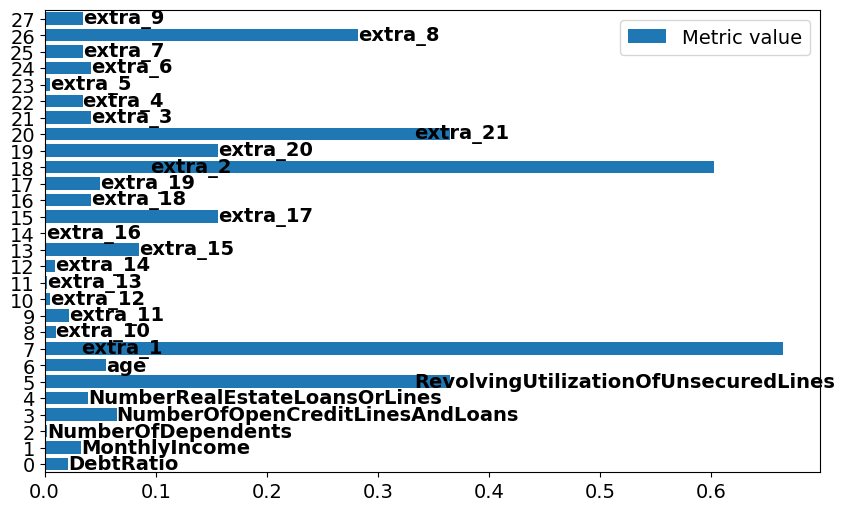

In [281]:
plot_bar_chart(df_val_corr_bn_old, fontsize=14)

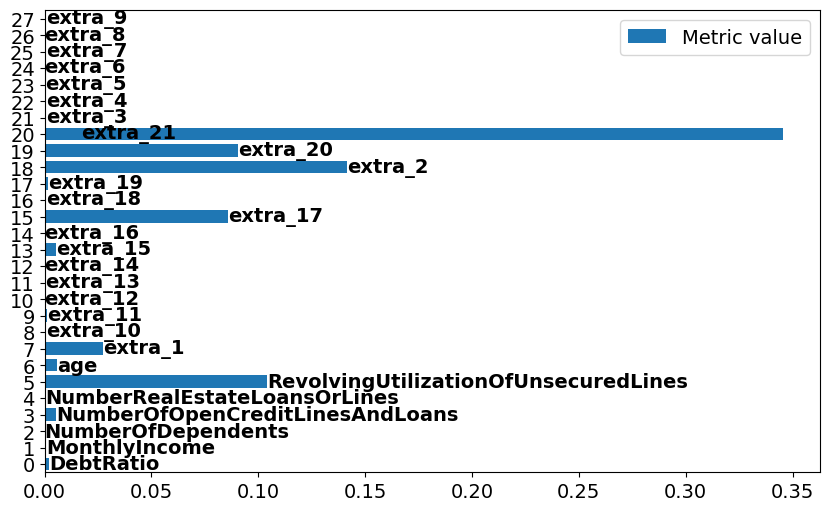

In [282]:
plot_bar_chart(df_val_corr_bn, fontsize=14)

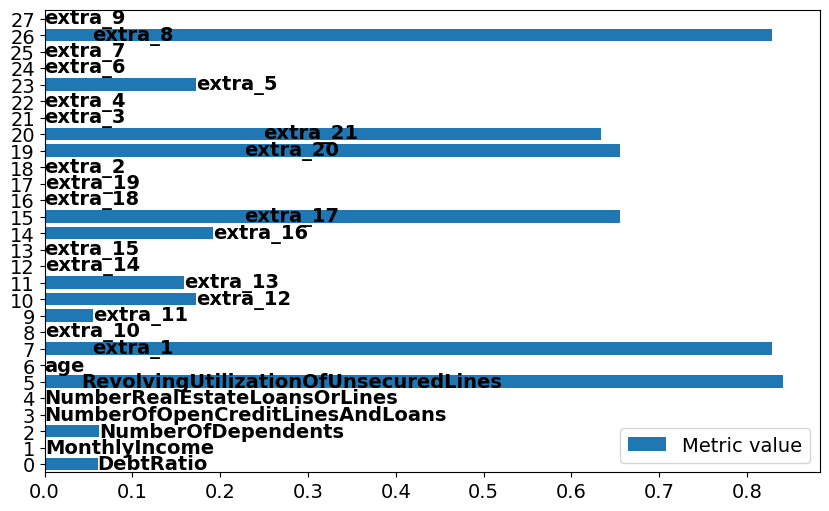

In [283]:
plot_bar_chart(df_val_corr_univ, fontsize=14)

In [284]:
df_corr_excluded_asc=elimination_experiment(model_corr, data_dict_corr, metric_dict,
                       df_val_corr_bn, 'asc')
df_corr_excluded_asc

,n_features,last_excluded,ROC AUC,log_loss,"ROC AUC_change, %","log_loss_change, %"
0,28,-,80.092,0.391,0,0
1,27,NumberOfDependents,80.092,0.391,0.0,0.085
2,26,extra_6,80.092,0.391,0.0,0.085
3,25,extra_12,80.092,0.391,0.0,0.085
4,24,extra_8,80.092,0.391,0.0,0.085
5,23,extra_14,80.092,0.391,0.0,0.085
6,22,extra_16,80.113,0.391,0.026,-0.035
7,21,extra_5,79.987,0.392,-0.131,0.306
8,20,extra_13,80.202,0.391,0.137,0.011
9,19,NumberRealEstateLoansOrLines,80.202,0.391,0.137,0.011


In [285]:
df_corr_excluded_asc[df_corr_excluded_asc['ROC AUC']==df_corr_excluded_asc['ROC AUC'].max()]

,n_features,last_excluded,ROC AUC,log_loss,"ROC AUC_change, %","log_loss_change, %"
8,20,extra_13,80.202,0.391,0.137,0.011
9,19,NumberRealEstateLoansOrLines,80.202,0.391,0.137,0.011


In [286]:
df_corr_excluded_asc_univ=elimination_experiment(model_corr, data_dict_corr, metric_dict,
                       df_val_corr_univ, 'asc')
df_corr_excluded_asc_univ

,n_features,last_excluded,ROC AUC,log_loss,"ROC AUC_change, %","log_loss_change, %"
0,28,-,80.092,0.391,0,0
1,27,NumberOfOpenCreditLinesAndLoans,80.077,0.391,-0.018,0.107
2,26,extra_15,80.112,0.391,0.025,0.03
3,25,extra_4,80.102,0.391,0.013,0.11
4,24,NumberRealEstateLoansOrLines,80.102,0.391,0.013,0.11
5,23,extra_6,80.102,0.391,0.013,0.11
6,22,extra_3,80.102,0.391,0.013,0.11
7,21,extra_18,80.319,0.39,0.283,-0.182
8,20,age,80.043,0.392,-0.061,0.178
9,19,extra_2,80.3,0.39,0.259,-0.349


In [287]:
df_corr_excluded_asc_univ[df_corr_excluded_asc_univ['ROC AUC']==df_corr_excluded_asc_univ['ROC AUC'].max()]

,n_features,last_excluded,ROC AUC,log_loss,"ROC AUC_change, %","log_loss_change, %"
7,21,extra_18,80.319,0.39,0.283,-0.182


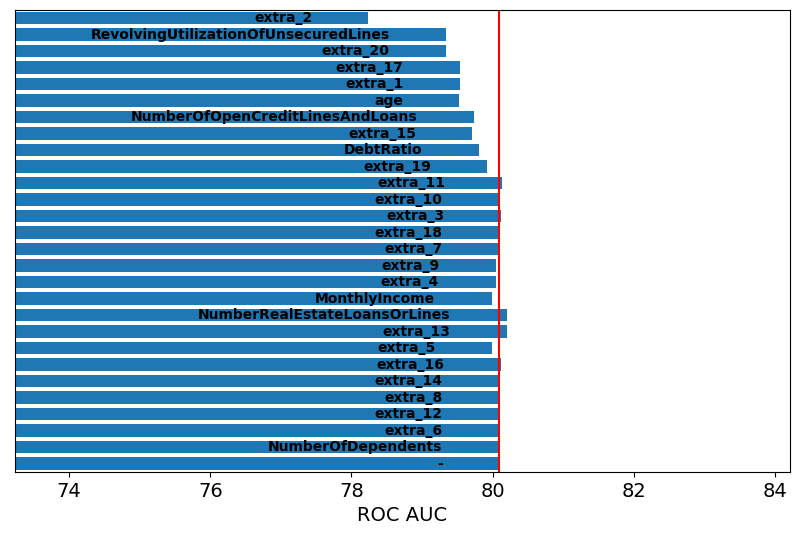

In [288]:
metr = 'ROC AUC'
df_corr_excluded_asc[['last_excluded', metr]].plot.barh(figsize=(10, 6))
ax=plt.gca()
ax.barh(df_corr_excluded_asc['last_excluded'], df_corr_excluded_asc[metr], height=0.75)
_, xmax = plt.xlim()
#ax.set_xlim((df_corr_excluded_asc[metr].min()-10, xmax))
for i, row in df_corr_excluded_asc.iterrows():
    ax.text(row[metr]*0.99,# if 2*row[metr] < xmax else xmax-row[metr], 
            i, row['last_excluded'], color='black', fontweight='bold', fontsize=10, ha='right', va='center')
ax.set_xlim((df_corr_excluded_asc[metr].min()-5, xmax))
ax.axvline(df_corr_excluded_asc.loc[0, metr], color='red')
ax.get_legend().remove()
ax.set_xlabel(metr)
ax.set_ylabel('Last removed feature')
ax.get_yaxis().set_visible(False)


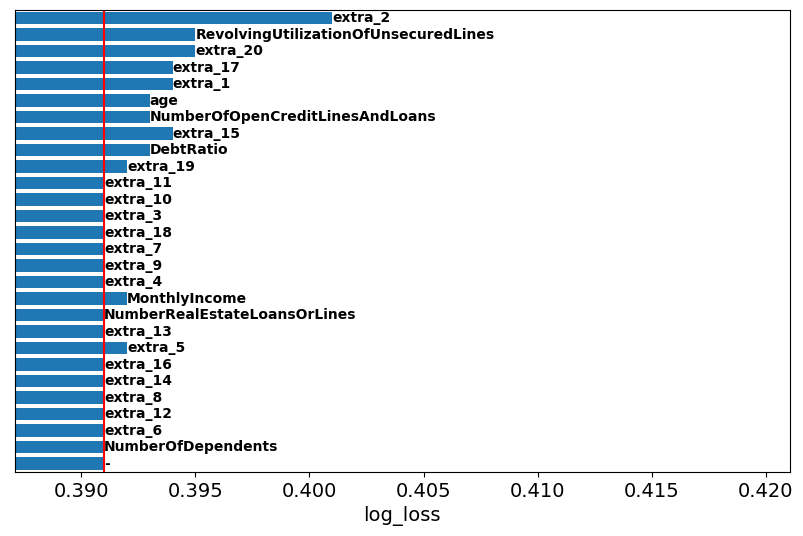

In [289]:
metr = 'log_loss'
df_corr_excluded_asc[['last_excluded', metr]].plot.barh(figsize=(10, 6))
ax=plt.gca()
ax.barh(df_corr_excluded_asc['last_excluded'], df_corr_excluded_asc[metr], height=0.75)
_, xmax = plt.xlim()
#ax.set_xlim((df_corr_excluded_asc[metr].min()-10, xmax))
for i, row in df_corr_excluded_asc.iterrows():
    ax.text(row[metr],# if 2*row[metr] < xmax else xmax-row[metr], 
            i, row['last_excluded'], color='black', fontweight='bold', fontsize=10, ha='left', va='center')
ax.set_xlim((df_corr_excluded_asc[metr].min()*0.99, xmax))
ax.axvline(df_corr_excluded_asc.loc[0, metr], color='red')
ax.get_legend().remove()
ax.set_xlabel(metr)
ax.set_ylabel('Last removed feature')
ax.get_yaxis().set_visible(False)


In [290]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [291]:
rfe_sel = RFE(estimator=DecisionTreeClassifier(random_state=42, max_depth=10,), n_features_to_select=1)
#rfe_sel = RFE(estimator=RandomForestClassifier(random_state=42, max_depth=10, n_estimators=50), n_features_to_select=1, )
rfe_sel.fit(data_dict_corr['val'][features_corr], data_dict_corr['val'][target])

RFE(estimator=DecisionTreeClassifier(max_depth=10, random_state=42),
    n_features_to_select=1)

In [292]:
rfe_support = [x for i, x in enumerate(rfe_sel.feature_names_in_) if rfe_sel.ranking_[i]==1]

In [293]:
rfe_sel.feature_names_in_

array(['DebtRatio', 'MonthlyIncome', 'NumberOfDependents',
       'NumberOfOpenCreditLinesAndLoans', 'NumberRealEstateLoansOrLines',
       'RevolvingUtilizationOfUnsecuredLines', 'age', 'extra_1',
       'extra_10', 'extra_11', 'extra_12', 'extra_13', 'extra_14',
       'extra_15', 'extra_16', 'extra_17', 'extra_18', 'extra_19',
       'extra_2', 'extra_20', 'extra_21', 'extra_3', 'extra_4', 'extra_5',
       'extra_6', 'extra_7', 'extra_8', 'extra_9'], dtype=object)

In [294]:
df_val_corr_rfe = copy(df_val_corr_bn_old)
df_val_corr_rfe['Feature']=rfe_sel.feature_names_in_
df_val_corr_rfe['Metric value']=rfe_sel.ranking_
df_val_corr_rfe

,Feature,Metric value
0,DebtRatio,6
1,MonthlyIncome,8
2,NumberOfDependents,27
3,NumberOfOpenCreditLinesAndLoans,19
4,NumberRealEstateLoansOrLines,28
5,RevolvingUtilizationOfUnsecuredLines,1
6,age,17
7,extra_1,3
8,extra_10,20
9,extra_11,2


In [295]:
df_corr_excluded_rfe=elimination_experiment(model_corr, data_dict_corr, metric_dict,
                       df_val_corr_rfe, 'desc')
df_corr_excluded_rfe

,n_features,last_excluded,ROC AUC,log_loss,"ROC AUC_change, %","log_loss_change, %"
0,28,-,80.092,0.391,0,0
1,27,NumberRealEstateLoansOrLines,80.092,0.391,0.0,0.085
2,26,NumberOfDependents,80.092,0.391,0.0,0.085
3,25,extra_14,80.092,0.391,0.0,0.085
4,24,extra_7,80.092,0.391,0.0,0.085
5,23,extra_3,80.092,0.391,0.0,0.085
6,22,extra_18,80.092,0.391,0.0,0.085
7,21,extra_6,80.311,0.39,0.274,-0.138
8,20,extra_13,80.311,0.39,0.274,-0.138
9,19,extra_10,80.311,0.39,0.274,-0.138


In [296]:
df_corr_excluded_rfe[df_corr_excluded_rfe['ROC AUC']==df_corr_excluded_rfe['ROC AUC'].max()]

,n_features,last_excluded,ROC AUC,log_loss,"ROC AUC_change, %","log_loss_change, %"
7,21,extra_6,80.311,0.39,0.274,-0.138
8,20,extra_13,80.311,0.39,0.274,-0.138
9,19,extra_10,80.311,0.39,0.274,-0.138


In [ ]:
# наша метрика -- это же по сути взаимная информация

In [71]:
from sklearn.feature_selection import mutual_info_classif

In [72]:
mutual_info_classif(X=disc_data[['age']], y=disc_data['inconf_error'])

array([0.05289194])

In [63]:
disc_data

,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfDependents,inconf_error
0,2,1,0,0,0,1,0,2
1,2,0,0,0,0,1,0,2
2,1,1,0,2,0,2,1,0
3,0,2,1,0,0,2,0,0
4,1,0,2,1,0,2,2,1
...,...,...,...,...,...,...,...,...
2126,2,0,0,0,0,1,1,2
2127,2,0,0,1,0,1,0,2
2128,1,1,0,2,1,2,1,1
2129,2,0,0,1,0,1,0,2


In [ ]:
from gzip import GzipFile
from io import BytesIO
# import logging
from os.path import exists, join
try:
    from urllib2 import urlopen
except ImportError:
    from urllib.request import urlopen

import numpy as np

from sklearn.datasets import get_data_home
from sklearn.datasets import Bunch, _pkl_filepath, B
from sklearn.utils.fixes import makedirs
from sklearn.externals import joblib
from sklearn.utils import check_random_state

URL = ('https://archive.ics.uci.edu/ml/'
       'machine-learning-databases/00280/HIGGS.csv.gz')

# logger = logging.getLogger()


def fetch_higgs(data_home=None,
                download_if_missing=True,
                random_state=None,
                shuffle=False):
    """Load the Higgs dataset, downloading it if necessary.

    Read more in the :ref:`User Guide <datasets>`.

    Parameters
    ----------
    data_home : string, optional
        Specify another download and cache folder for the datasets. By default
        all scikit learn data is stored in '~/scikit_learn_data' subfolders.

    download_if_missing : boolean, default=True
        If False, raise a IOError if the data is not locally available
        instead of trying to download the data from the source site.

    random_state : int, RandomState instance or None, optional (default=None)
        Random state for shuffling the dataset.
        If int, random_state is the seed used by the random number generator;
        If RandomState instance, random_state is the random number generator;
        If None, the random number generator is the RandomState instance used
        by `np.random`.

    shuffle : bool, default=False
        Whether to shuffle dataset.

    Returns
    -------
    dataset : dict-like object with the following attributes:

    dataset.data : numpy array of shape (11000000, 28)
        Each row corresponds to the 28 features in the dataset.

    dataset.target : numpy array of shape (11000000,)
        The targets are binary: 0 (background) - 1 (signal).

    dataset.DESCR : string
        Description of the Higgs dataset.
    """

    data_home = get_data_home(data_home=data_home)
    higgs_dir = join(data_home, "higgs")
    samples_path = _pkl_filepath(higgs_dir, "samples")
    targets_path = _pkl_filepath(higgs_dir, "targets")
    available = exists(samples_path)

    if download_if_missing and not available:
        makedirs(higgs_dir, exist_ok=True)
        # logger.warning("Downloading %s" % URL)
        print("Downloading {}".format(URL))
        f = BytesIO(urlopen(URL).read())
        Xy = np.genfromtxt(GzipFile(fileobj=f), delimiter=',',
                           dtype=np.float32)

        X = Xy[:, 1::]
        y = Xy[:, 0].astype(np.int32)

        joblib.dump(X, samples_path, compress=9)
        joblib.dump(y, targets_path, compress=9)
        print("Dumped the data")

    try:
        X, y
    except NameError:
        X = joblib.load(samples_path)
        y = joblib.load(targets_path)
        print("Data loaded from pickle")

    if shuffle:
        ind = np.arange(X.shape[0])
        rng = check_random_state(random_state)
        rng.shuffle(ind)
        X = X[ind]
        y = y[ind]

    return Bunch(data=X, target=y, DESCR=__doc__)

ModuleNotFoundError: No module named 'sklearn.datasets.base'